In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
style_image_path ='/content/style1.jpeg'
style_image_path_2 = '/content/wave.jpg'

base_image_path = '/content/suii.jpeg'

In [ ]:
imsize = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader(style_image_path)
style_img_2 = image_loader(style_image_path_2)
content_img = image_loader(base_image_path)

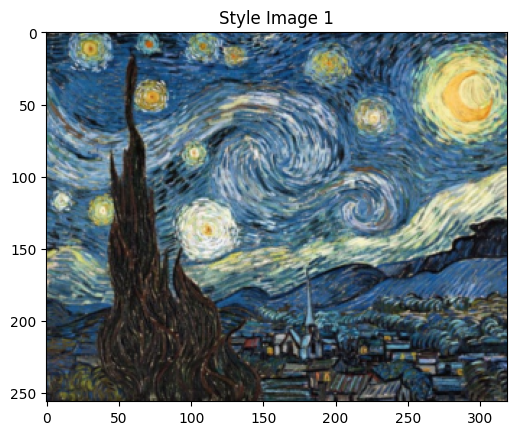

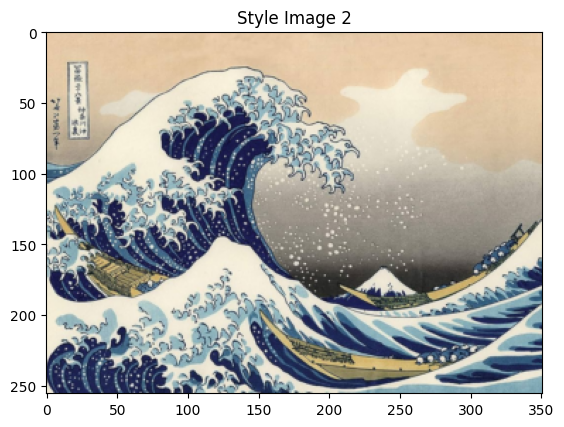

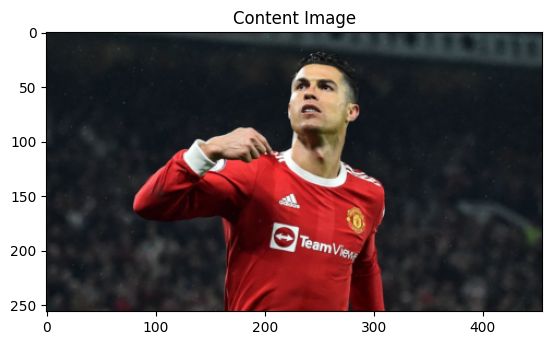

In [ ]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image 1')

plt.figure()
imshow(style_img_2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a * b, c * d)

    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:13<00:00, 42.2MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_14']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

In [ ]:
i = 0
j = 1
k = 0

for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        k +=1
        name = 'conv_{}'.format(i)
        print(name,':' ,'block_',j, 'conv_',k)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)

        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
        j += 1
        k = 0
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

conv_1 : block_ 1 conv_ 1
conv_2 : block_ 1 conv_ 2
conv_3 : block_ 2 conv_ 1
conv_4 : block_ 2 conv_ 2
conv_5 : block_ 3 conv_ 1
conv_6 : block_ 3 conv_ 2
conv_7 : block_ 3 conv_ 3
conv_8 : block_ 3 conv_ 4
conv_9 : block_ 4 conv_ 1
conv_10 : block_ 4 conv_ 2
conv_11 : block_ 4 conv_ 3
conv_12 : block_ 4 conv_ 4
conv_13 : block_ 5 conv_ 1
conv_14 : block_ 5 conv_ 2
conv_15 : block_ 5 conv_ 3
conv_16 : block_ 5 conv_ 4


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)


    normalization = Normalization(normalization_mean, normalization_std).to(device)


    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:

            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)



    return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):

    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=50,
                       style_weight=100, content_weight=1):

    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():

            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()


            return style_score + content_score

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)

    return input_img

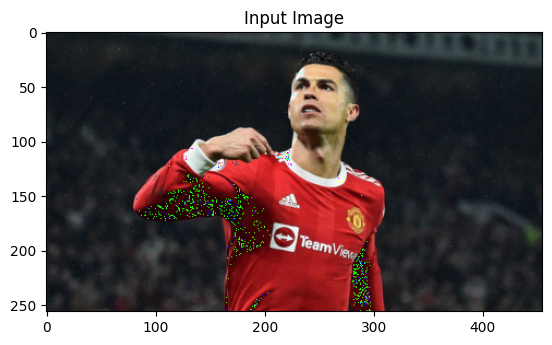

In [ ]:
input_img = content_img.clone() + 0.01*torch.randn(content_img.data.size(), device=device)
plt.figure()
imshow(input_img, title='Input Image')

Building the style transfer model..


<ipython-input-11-9d0e31e1cc8b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-11-9d0e31e1cc8b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
i:  0


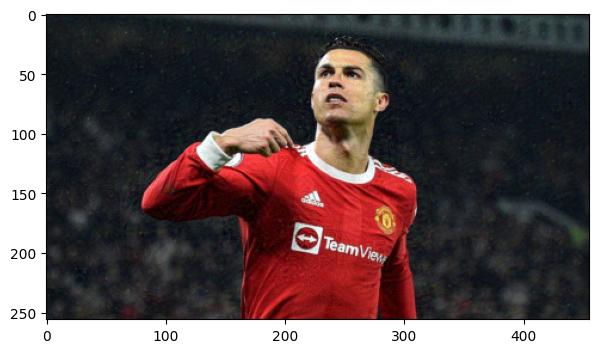

Building the style transfer model..
Optimizing..
i:  0


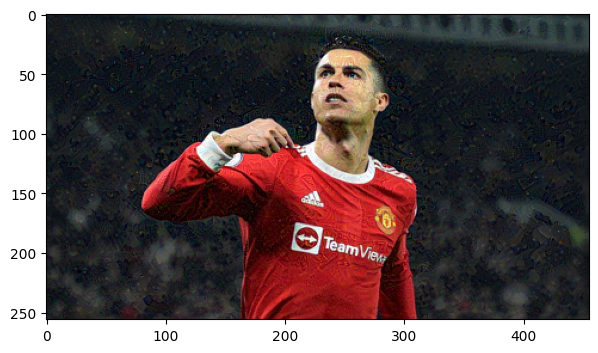

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
i:  10


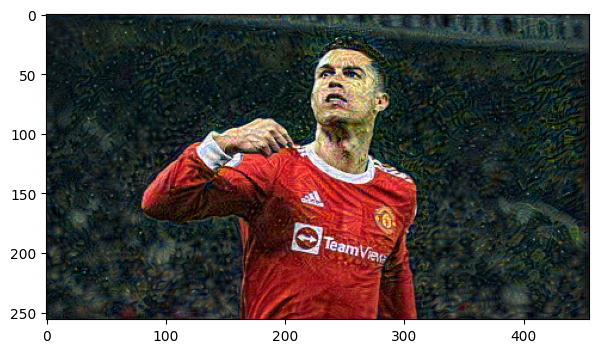

Building the style transfer model..
Optimizing..
i:  10


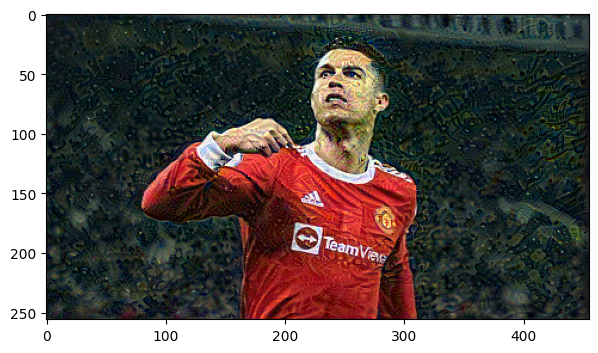

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
i:  20


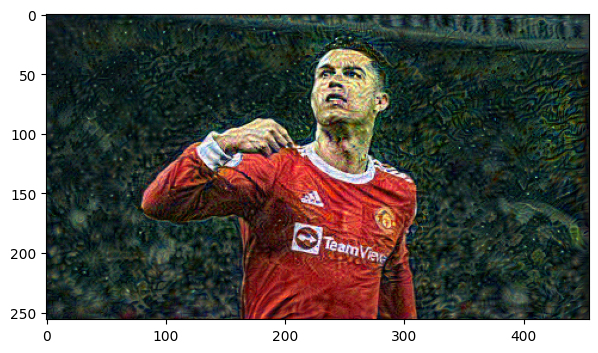

Building the style transfer model..
Optimizing..
i:  20


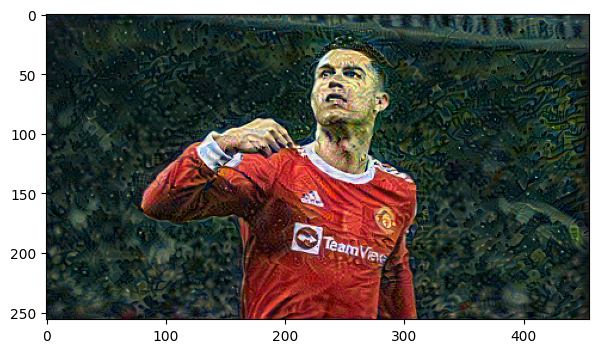

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
i:  30


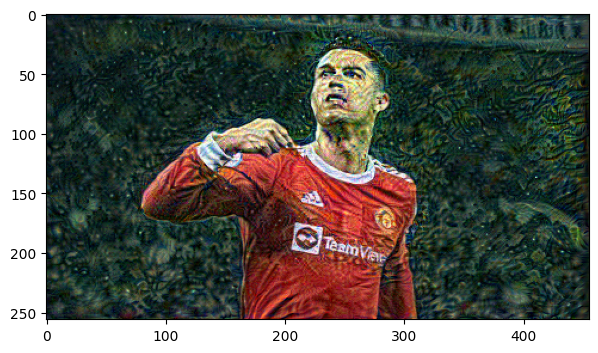

Building the style transfer model..
Optimizing..
i:  30


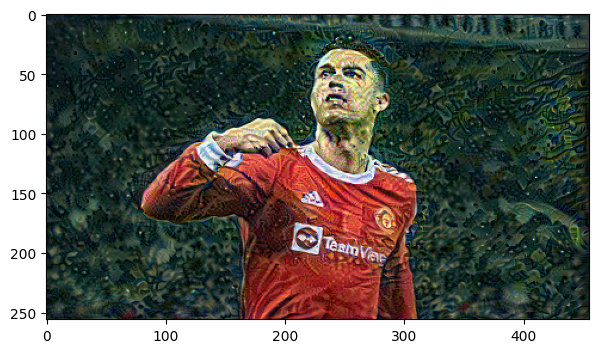

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
i:  40


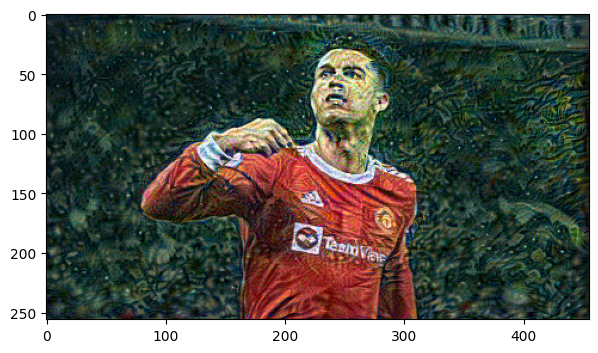

Building the style transfer model..
Optimizing..
i:  40


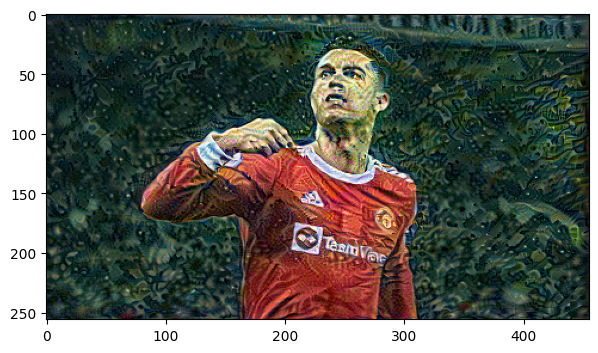

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
i:  50


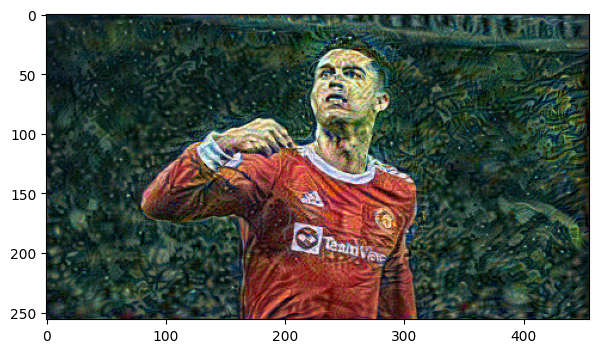

Building the style transfer model..
Optimizing..
i:  50


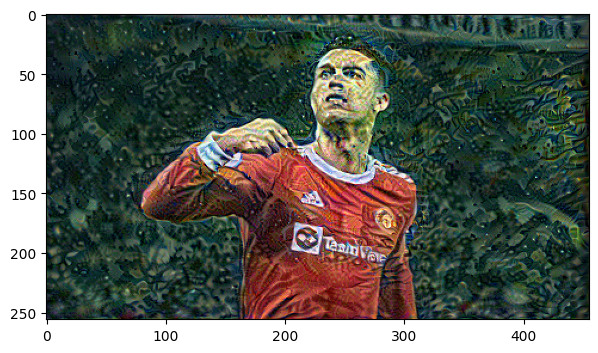

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


In [ ]:
output = input_img
for i in range(60):
    for j in range(2):
        if j ==0:
            SI = style_img
            style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

        if j ==1:
            SI = style_img_2
            style_layers_default = ['conv_2', 'conv_4', 'conv_6', 'conv_10', 'conv_14']

        output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, SI, output, num_steps=10)
        if i % 10 == 0:
            print('i: ', i)
            plt.figure(figsize=(7,10))
            image = output.cpu().clone()
            image = image.squeeze(0)
            image = unloader(image)
            plt.imshow(image)

            plt.ioff()
            plt.show()

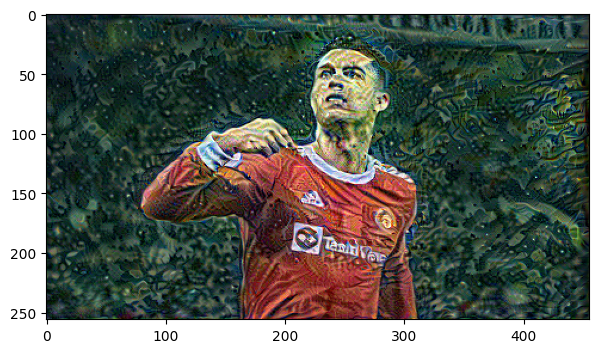

In [ ]:
plt.figure(figsize=(7,10))
image = output.cpu().clone()
image = image.squeeze(0)
image = unloader(image)
plt.imshow(image)

plt.ioff()
plt.show()